<a href="https://colab.research.google.com/github/hamin32/Extracurricular-activities/blob/main/%EC%94%80%EC%94%80%EC%9D%B41.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#모든 변수를 한꺼번에 VAR에 넣는 방식

In [2]:
# ============================
# 1. 라이브러리 불러오기
# ============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

plt.rcParams["figure.figsize"] = (10, 6)

# ============================
# 2. 데이터 불러오기
# ============================
path = "/content/model_sales_with_macro_2020_2025.csv"

df = pd.read_csv(path, parse_dates=["date"])

print(df.head())
print(df.columns)



   Year  Month             Model    Sales       date  krw_per_usd  \
0  2020      1       Accent (RB)      0.0 2020-01-01  1167.462381   
1  2020      1       Avante (AD)  12829.0 2020-01-01  1167.462381   
2  2020      1      Avante (CN7)      1.0 2020-01-01  1167.462381   
3  2020      1  Avante (CN7 HEV)      0.0 2020-01-01  1167.462381   
4  2020      1    IONIQ (AE HEV)   4589.0 2020-01-01  1167.462381   

   Trade_Balance   USD_Index    WTI_Oil  Brent_Oil  ...  Unemployment_Rate  \
0       -43562.0  115.278581  57.519048  63.645455  ...                3.6   
1       -43562.0  115.278581  57.519048  63.645455  ...                3.6   
2       -43562.0  115.278581  57.519048  63.645455  ...                3.6   
3       -43562.0  115.278581  57.519048  63.645455  ...                3.6   
4       -43562.0  115.278581  57.519048  63.645455  ...                3.6   

   Fed_Funds_Rate    PPI  Trade_Balance_USD1000 CPI_KOR  CPI_KOR_core  \
0            1.55  199.3                384

In [3]:
# ============================
# 3. 월별 글로벌 총 판매량으로 집계
# ============================
monthly = (
    df.groupby("date", as_index=False)
      .agg({
          "Sales": "sum",
          "krw_per_usd": "first",
          "USD_Index": "first",
          "WTI_Oil": "first",
          "Brent_Oil": "first",
          "CPI_KOR": "first",
          "Fed_Funds_Rate": "first",
          "GSCPI": "first"
      })
)

print(monthly.head())
print(monthly.tail())

# 2025-06 이후는 macro 누락이 있으니 일단 제거 (2025-05까지 사용)
monthly = monthly[monthly["date"] <= "2025-05-01"].copy()

# 혹시라도 중간에 NaN 있는 행은 날림 (보수적 처리)
monthly = monthly.dropna(subset=[
    "Sales","krw_per_usd","USD_Index",
    "WTI_Oil","Brent_Oil","CPI_KOR",
    "Fed_Funds_Rate","GSCPI"
])

print("사용 기간:", monthly["date"].min(), "~", monthly["date"].max())
print("사용 관측치 수:", len(monthly))


        date     Sales  krw_per_usd   USD_Index    WTI_Oil  Brent_Oil  \
0 2020-01-01  123902.0  1167.462381  115.278581  57.519048  63.645455   
1 2020-02-01   89747.0  1195.335789  116.709490  50.542632  55.657000   
2 2020-03-01  161027.0  1218.194545  121.028546  29.207727  32.011364   
3 2020-04-01  117316.0  1223.130909  123.289350  16.547619  18.378500   
4 2020-05-01  111493.0  1228.134000  122.623760  28.562500  29.378947   

   CPI_KOR  Fed_Funds_Rate  GSCPI  
0   100.09            1.55   0.06  
1   100.16            1.58   1.30  
2    99.94            0.65   2.66  
3    99.50            0.05   3.36  
4    99.44            0.05   2.55  
         date     Sales  krw_per_usd  USD_Index  WTI_Oil  Brent_Oil  CPI_KOR  \
67 2025-08-01  152482.0          NaN        NaN      NaN        NaN      NaN   
68 2025-09-01  163521.0          NaN        NaN      NaN        NaN      NaN   
69 2025-10-01  140284.0          NaN        NaN      NaN        NaN      NaN   
70 2025-11-01       0.0  

##원시 시계열 확인

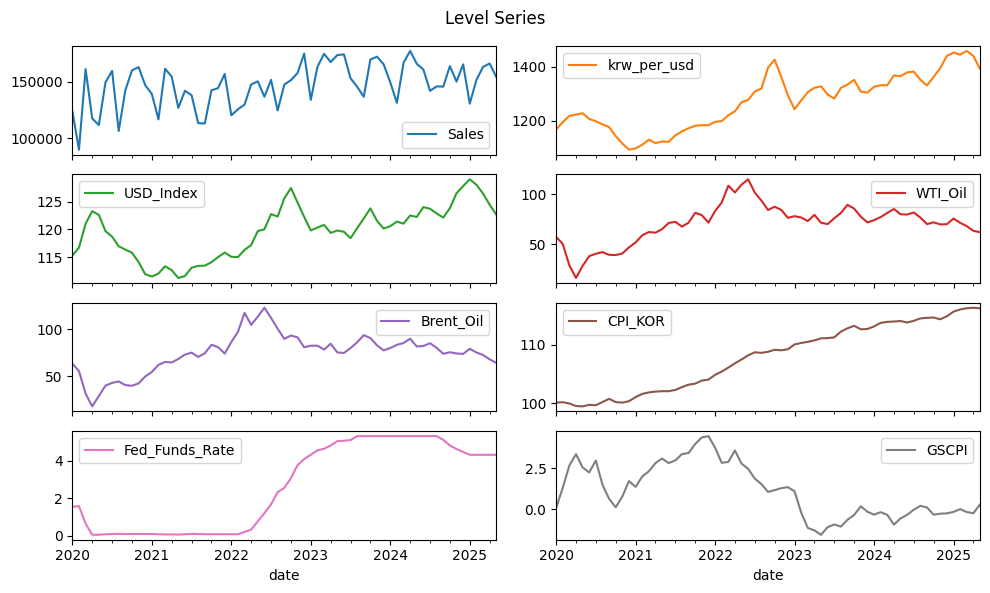

In [4]:
# ============================
# 4. 시계열 구조 만들기
# ============================
data = monthly.set_index("date")[[
    "Sales",
    "krw_per_usd",
    "USD_Index",
    "WTI_Oil",
    "Brent_Oil",
    "CPI_KOR",
    "Fed_Funds_Rate",
    "GSCPI"
]]

# 원시 시계열 확인용
data.plot(subplots=True, layout=(4,2), sharex=True, title="Level Series")
plt.tight_layout()
plt.show()


##ADF Test (단위근 검정)

In [5]:
# ============================
# 5. ADF Test (단위근 검정)
# ============================
def adf_test(series, name):
    series = series.dropna()
    result = adfuller(series, maxlag=4, autolag="AIC")
    stat, pvalue, usedlag, nobs = result[0], result[1], result[2], result[3]
    print(f"### {name} ###")
    print(f"ADF Statistic: {stat:.4f}")
    print(f"p-value      : {pvalue:.4f}")
    print(f"사용된 lag   : {usedlag}, 유효관측치: {nobs}")
    print("-"*40)

for col in data.columns:
    adf_test(data[col], col)


### Sales ###
ADF Statistic: -5.8462
p-value      : 0.0000
사용된 lag   : 0, 유효관측치: 64
----------------------------------------
### krw_per_usd ###
ADF Statistic: -0.6539
p-value      : 0.8583
사용된 lag   : 3, 유효관측치: 61
----------------------------------------
### USD_Index ###
ADF Statistic: -2.1000
p-value      : 0.2445
사용된 lag   : 1, 유효관측치: 63
----------------------------------------
### WTI_Oil ###
ADF Statistic: -1.9646
p-value      : 0.3023
사용된 lag   : 1, 유효관측치: 63
----------------------------------------
### Brent_Oil ###
ADF Statistic: -1.4472
p-value      : 0.5594
사용된 lag   : 0, 유효관측치: 64
----------------------------------------
### CPI_KOR ###
ADF Statistic: -0.3207
p-value      : 0.9225
사용된 lag   : 2, 유효관측치: 62
----------------------------------------
### Fed_Funds_Rate ###
ADF Statistic: -2.2387
p-value      : 0.1925
사용된 lag   : 3, 유효관측치: 61
----------------------------------------
### GSCPI ###
ADF Statistic: -1.7955
p-value      : 0.3827
사용된 lag   : 1, 유효관측치: 63
--------------

1차 차분 후 VAR 모형 추정

In [6]:
# ============================
# 6. 1차 차분 후 VAR 모형 추정
# ============================
data_diff = data.diff().dropna()

print(data_diff.head())

# VAR 모형 적합 (최대 2시차, AIC 기준)
model = VAR(data_diff)
results = model.fit(maxlags=2, ic="aic")

print(results.summary())


              Sales  krw_per_usd  USD_Index    WTI_Oil  Brent_Oil  CPI_KOR  \
date                                                                         
2020-02-01 -34155.0    27.873408   1.430909  -6.976416  -7.988455     0.07   
2020-03-01  71280.0    22.858756   4.319056 -21.334904 -23.645636    -0.22   
2020-04-01 -43711.0     4.936364   2.260804 -12.660108 -13.632864    -0.44   
2020-05-01  -5823.0     5.003091  -0.665590  12.014881  11.000447    -0.06   
2020-06-01  37714.0   -21.188091  -2.939201   9.744773  10.887871     0.27   

            Fed_Funds_Rate  GSCPI  
date                               
2020-02-01            0.03   1.24  
2020-03-01           -0.93   1.36  
2020-04-01           -0.60   0.70  
2020-05-01            0.00  -0.81  
2020-06-01            0.03  -0.31  
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 18, Nov, 2025
Time:                     06:15:12
--------------------------

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


##Granger 인과성 검정 (어떤 매크로가 Sales를 선행하는지)

In [7]:
# ============================
# 7. Granger Causality Test: Δmacro → ΔSales
# ============================
def granger_to_sales(df_diff, maxlag=2):
    target = "Sales"
    for col in df_diff.columns:
        if col == target:
            continue
        print(f"\n===== Granger Test: Δ{col} → Δ{target} =====")
        test_df = df_diff[[target, col]].dropna()
        try:
            grangercausalitytests(test_df, maxlag=maxlag, verbose=True)
        except Exception as e:
            print("Error:", e)

granger_to_sales(data_diff, maxlag=2)



===== Granger Test: Δkrw_per_usd → ΔSales =====

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3465  , p=0.5583  , df_denom=60, df_num=1
ssr based chi2 test:   chi2=0.3638  , p=0.5464  , df=1
likelihood ratio test: chi2=0.3628  , p=0.5470  , df=1
parameter F test:         F=0.3465  , p=0.5583  , df_denom=60, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.7199  , p=0.0744  , df_denom=57, df_num=2
ssr based chi2 test:   chi2=5.9169  , p=0.0519  , df=2
likelihood ratio test: chi2=5.6513  , p=0.0593  , df=2
parameter F test:         F=2.7199  , p=0.0744  , df_denom=57, df_num=2

===== Granger Test: ΔUSD_Index → ΔSales =====

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0050  , p=0.9440  , df_denom=60, df_num=1
ssr based chi2 test:   chi2=0.0052  , p=0.9424  , df=1
likelihood ratio test: chi2=0.0052  , p=0.9424  , df=1
parameter F test:         F=0.0050  , p=0.9440  , df_denom=60, df_num=1

Gra

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print resul

## Impulse Response Function (IRF)

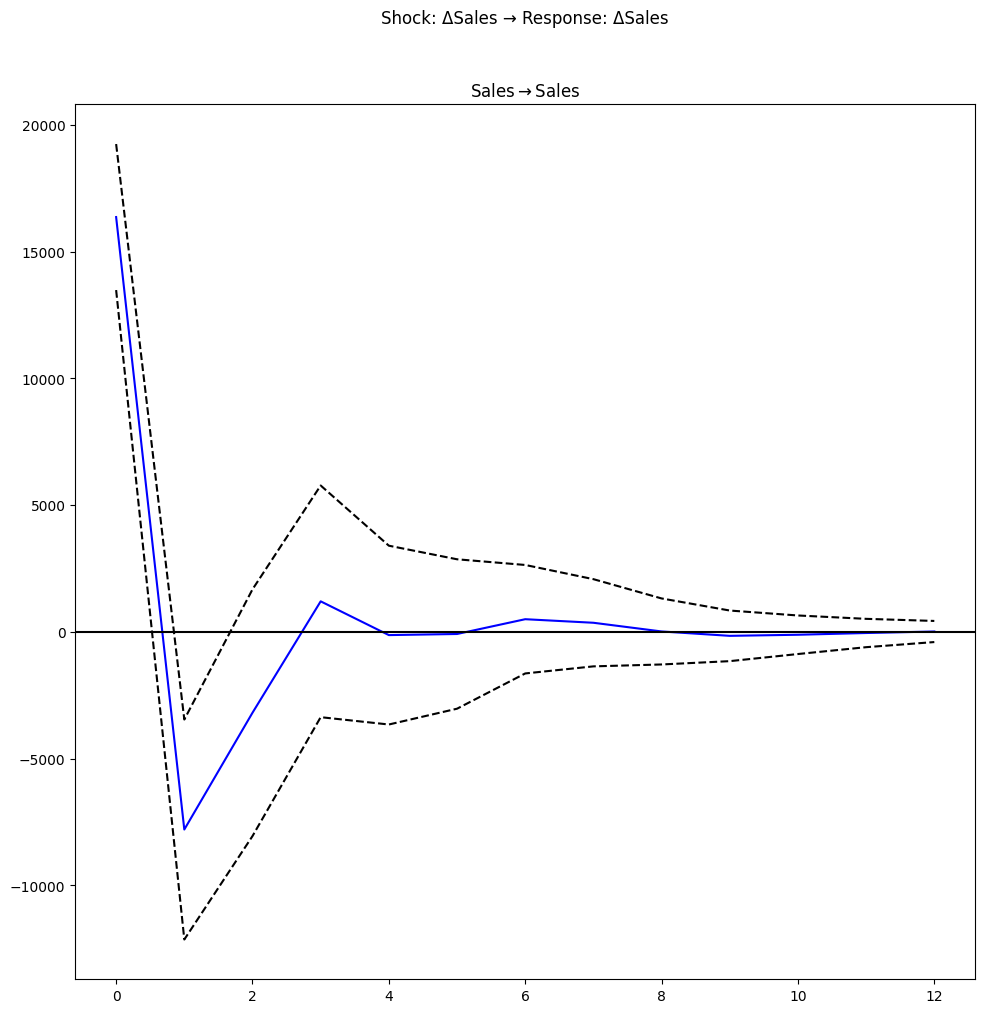

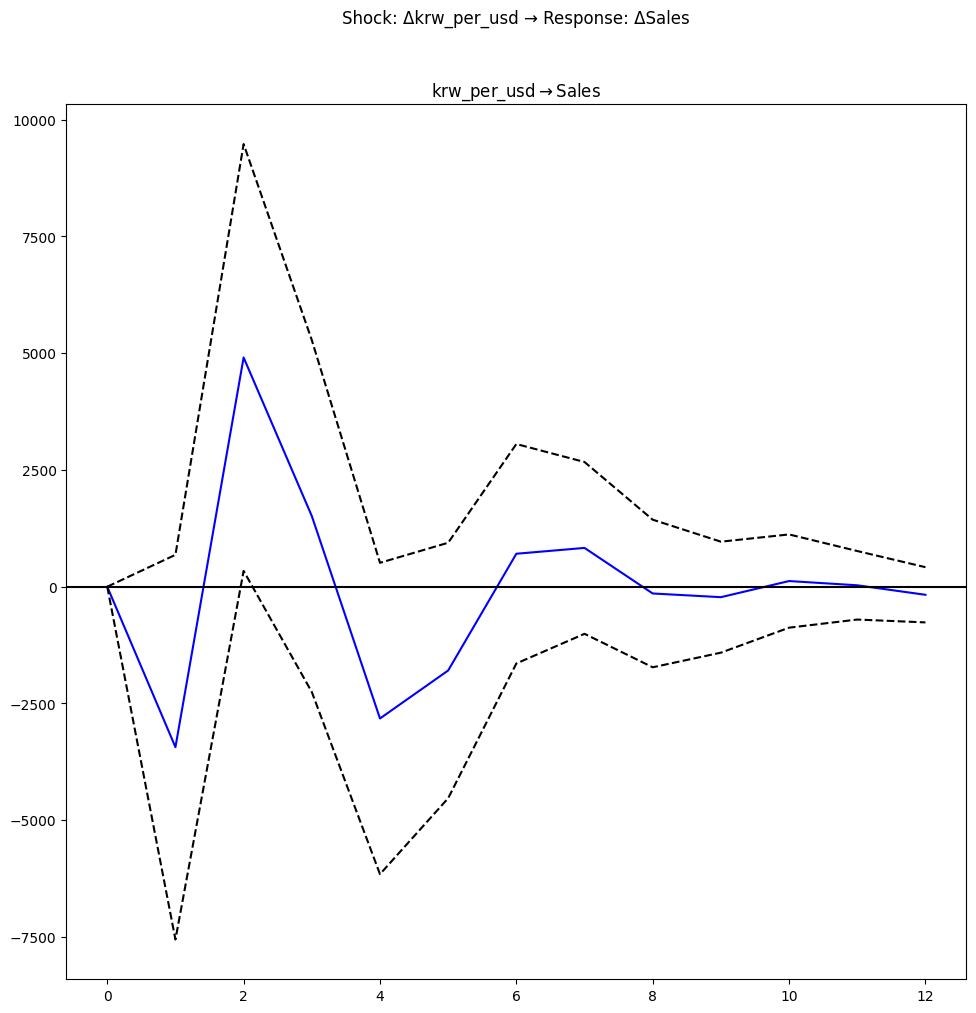

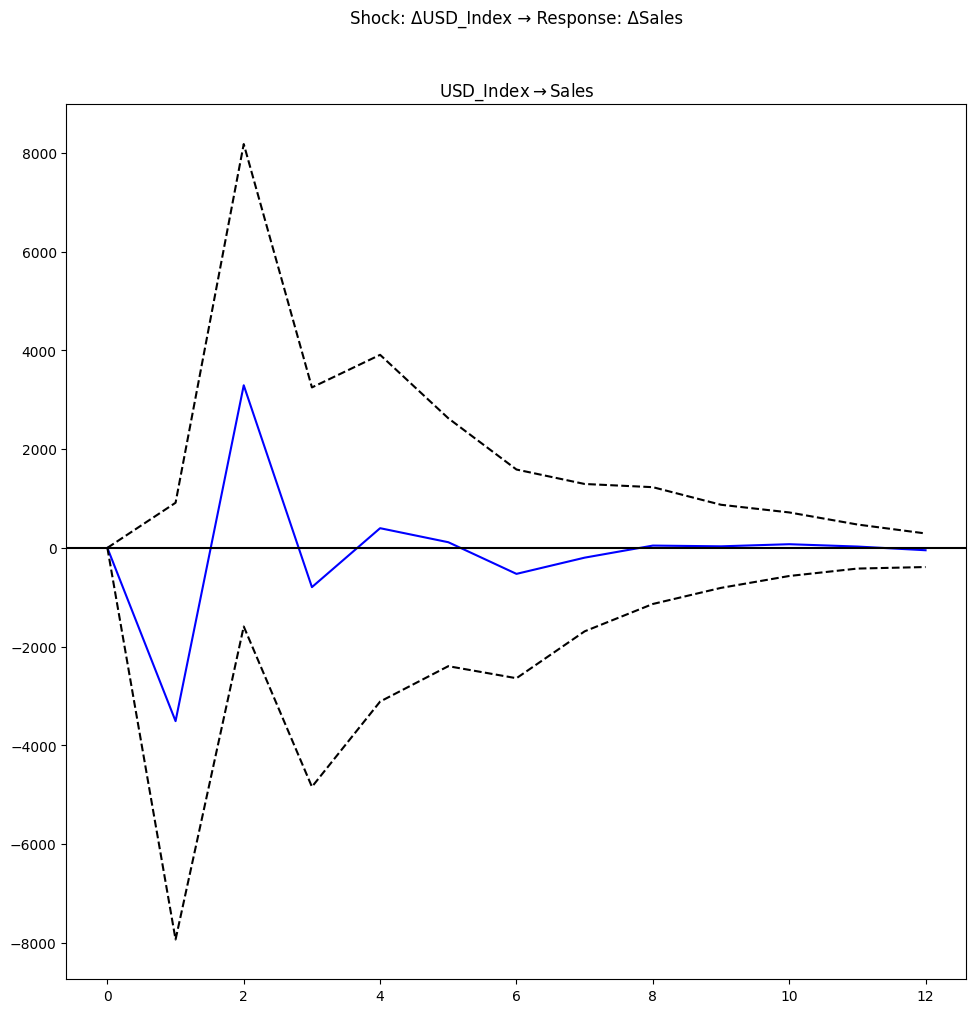

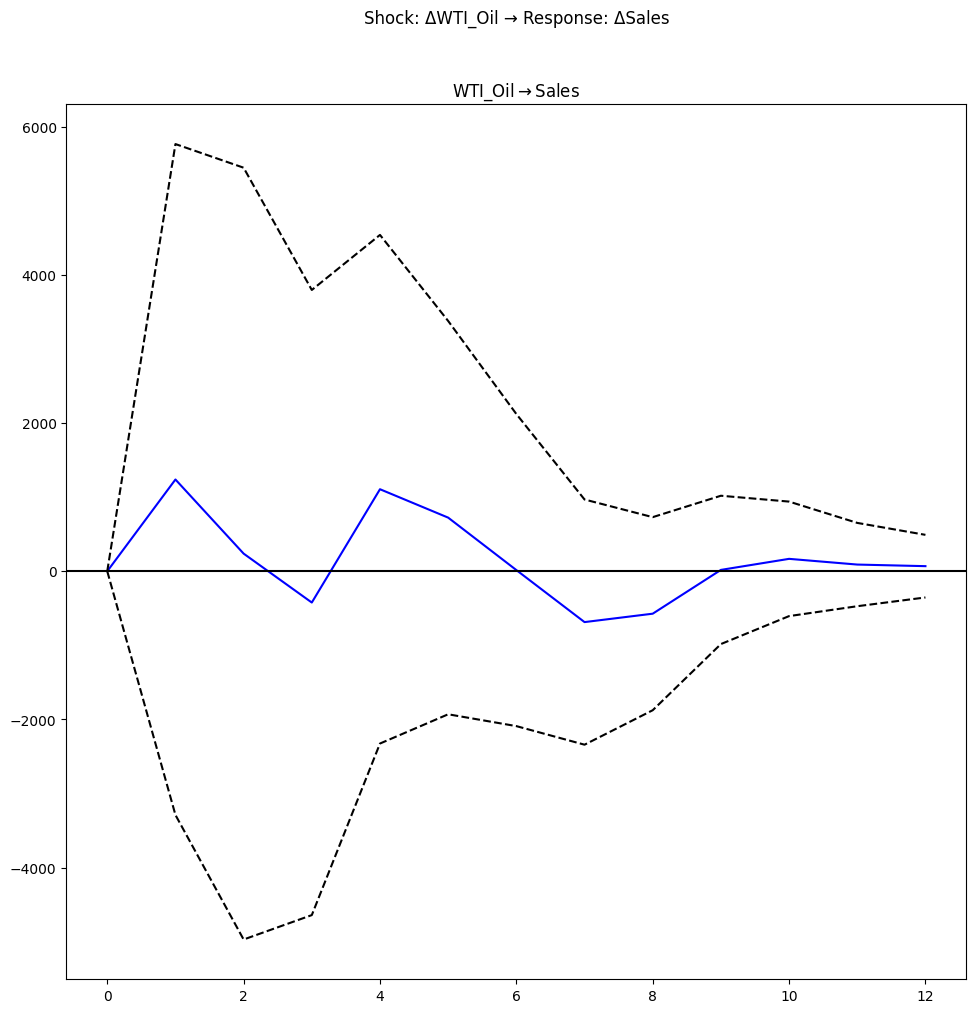

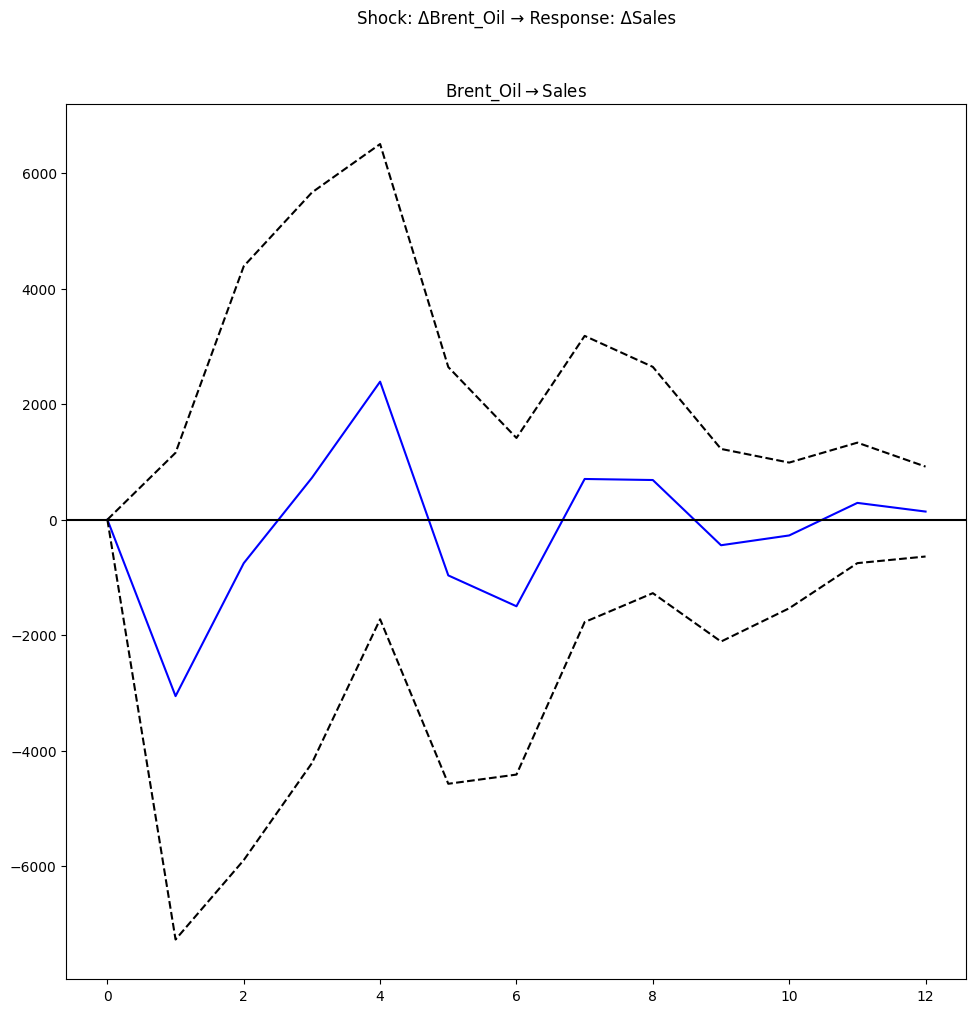

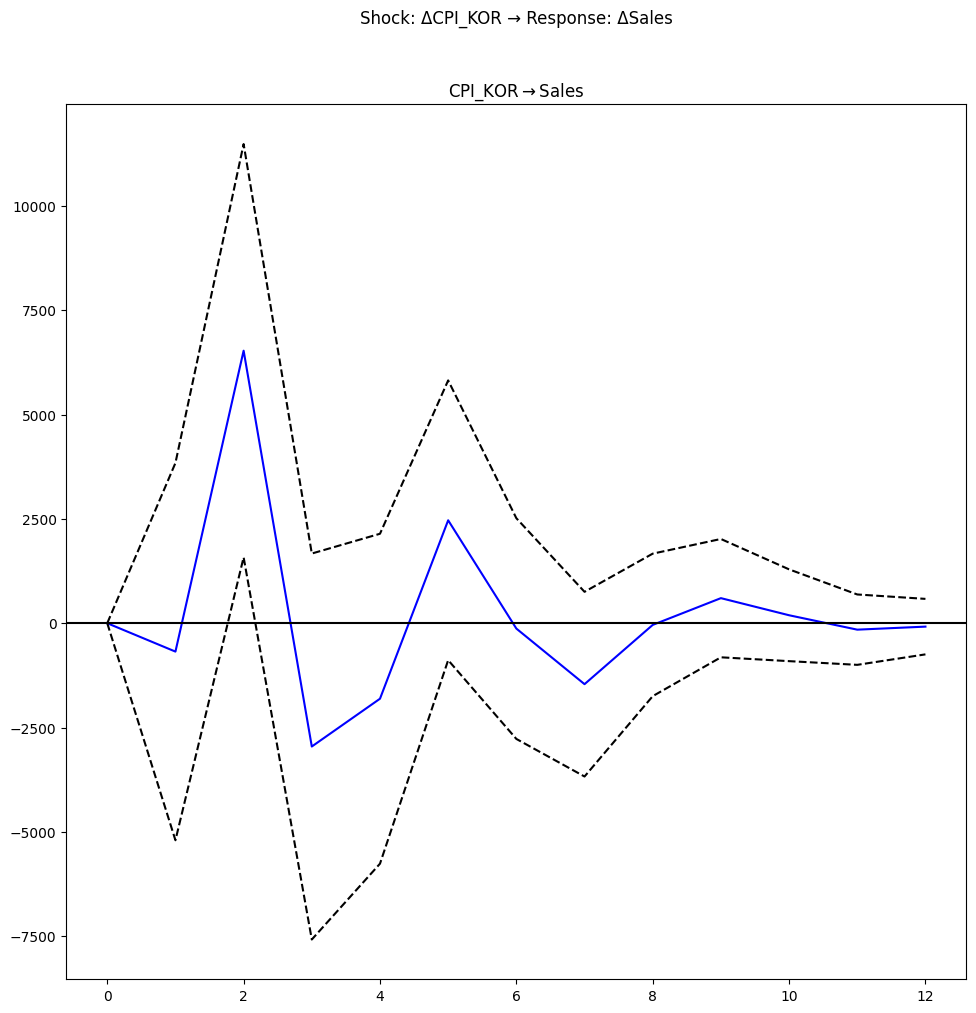

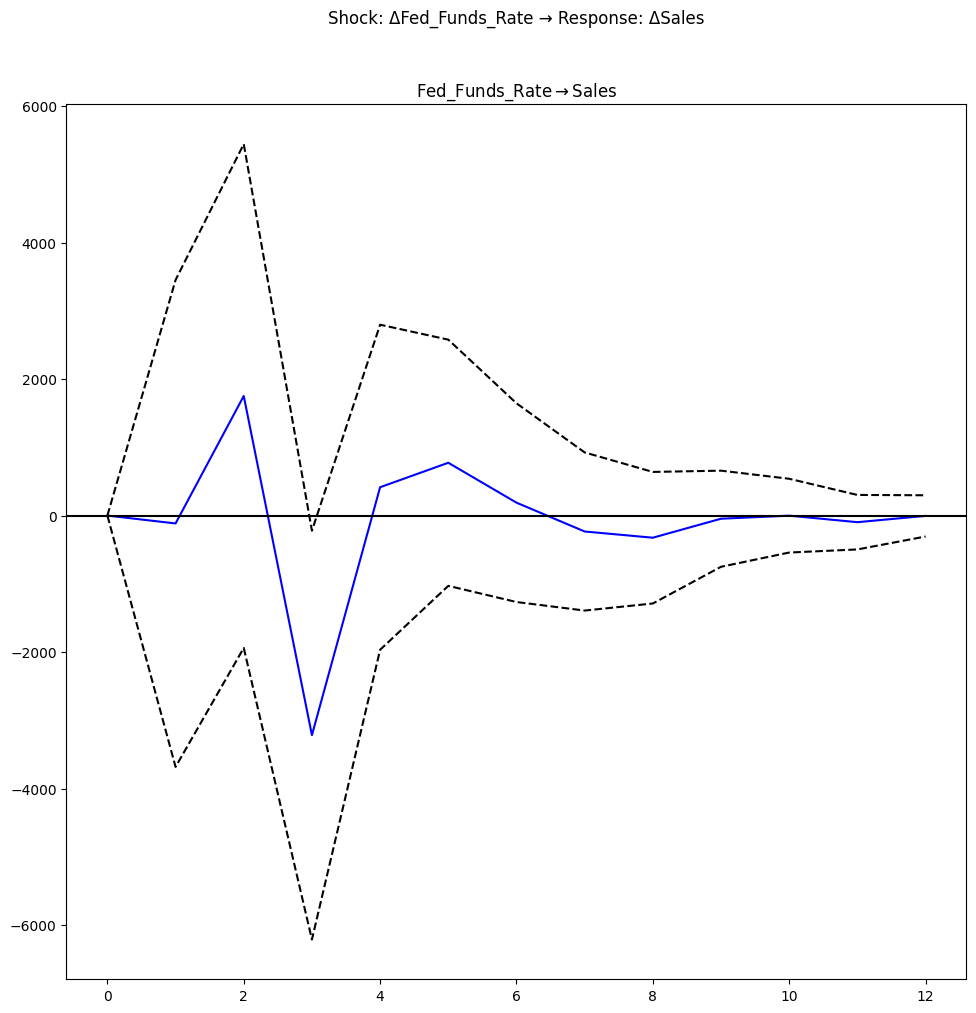

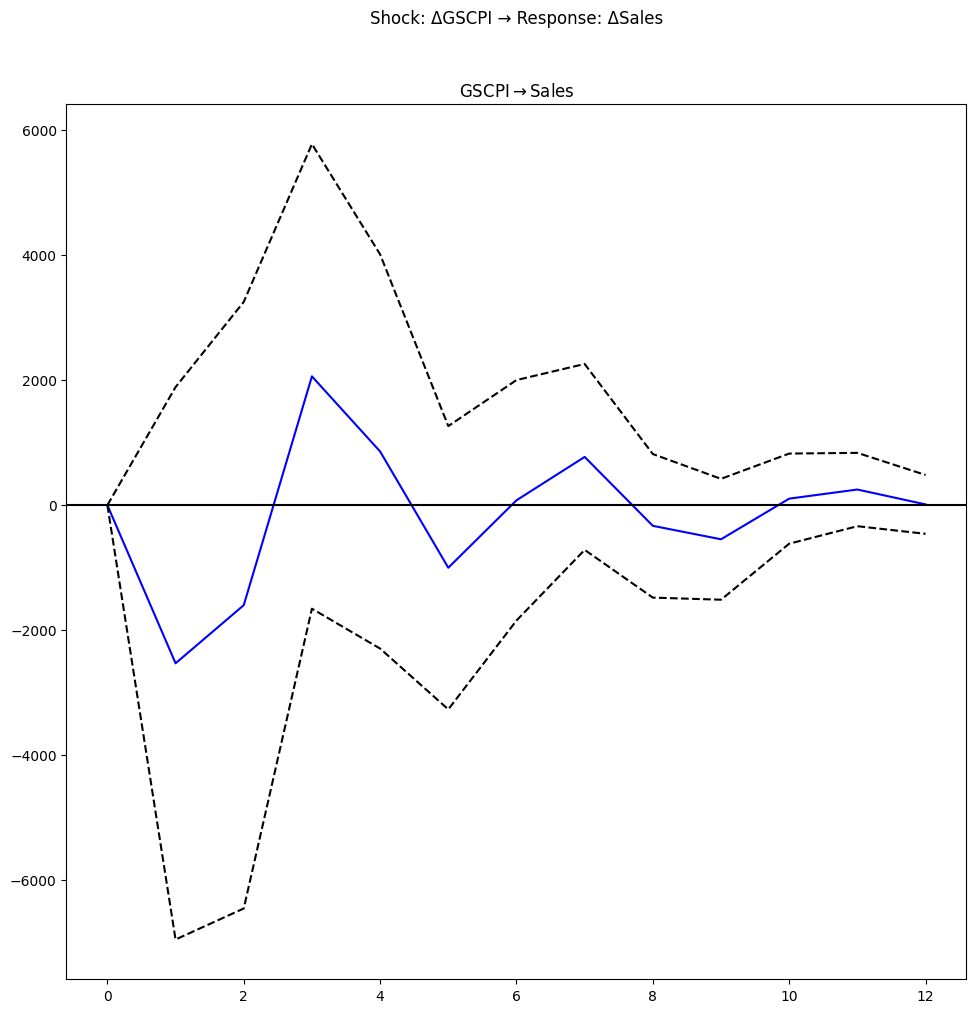

In [8]:
irf = results.irf(12)

target = "Sales"
variables = data_diff.columns

for var in variables:
    fig = irf.plot(orth=True, impulse=var, response=target)
    plt.suptitle(f"Shock: Δ{var} → Response: Δ{target}", y=1.02)
    plt.show()



##Forecast Error Variance Decomposition (FEVD)

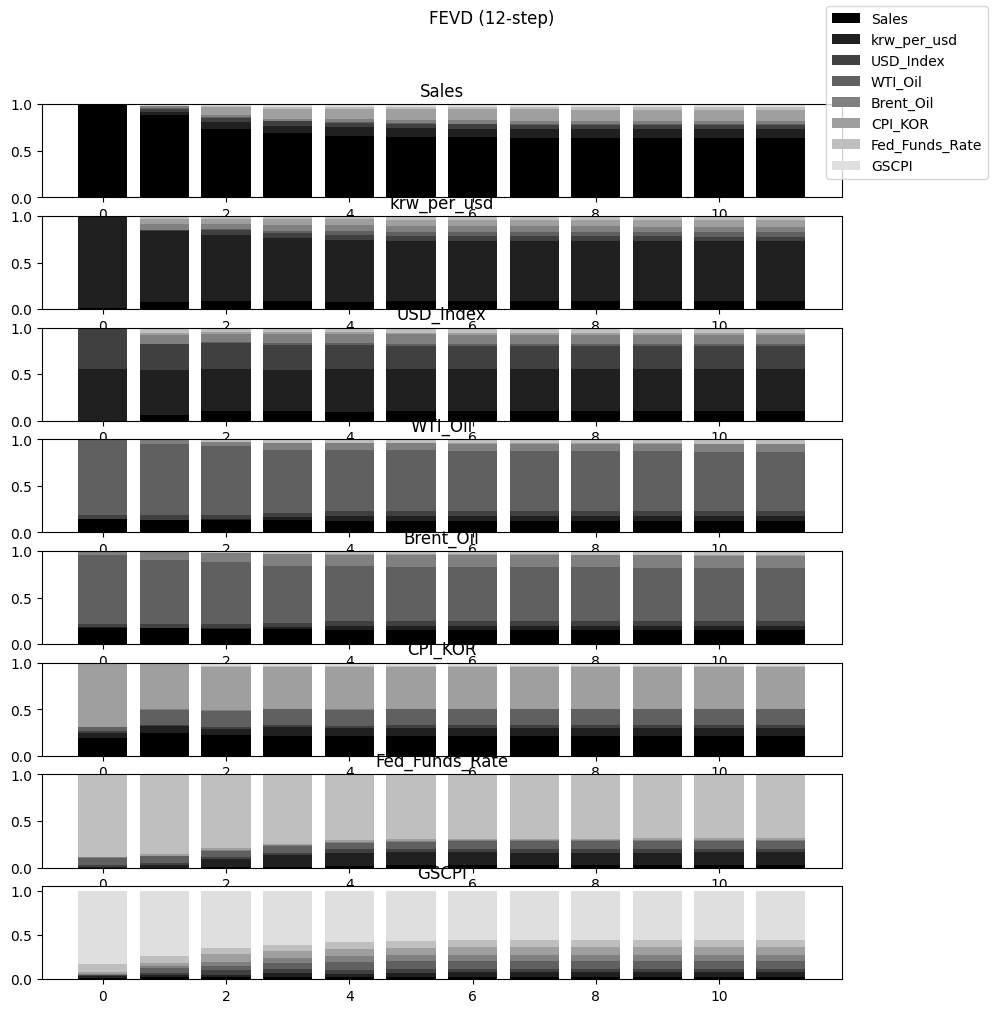


### Sales 의 12-step 분산 분해 결과 ###
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.09181861e-02 9.89081814e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.96001813e-05 5.61359890e-01 4.38600509e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.41173466e-01 7.17117961e-04 4.97129187e-02 8.08396498e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.78697173e-01 3.61248720e-03 3.95003141e-02 7.38540788e-01
  3.96492385e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.88976223e-01 5.66358059e-02 1.91607138e-02 4.99243989e-02
  1.18625643e-05 6.85290996e-01 0.00000000e+00 0.00000000e+00]
 [5.15857415e-04 1.05642726e-03 2.22339734e-02 7.95801152e-02
  7.32809038e-03 2.24166375e-05 8.89263120e-01 0.00000000e+00]
 [1.79203481e-02 1.87552198e-02 6.21344640e-03 1.94586966e-03
  1.36232657e-02 2.76705445e-

In [9]:
# ============================
# 9. Forecast Error Variance Decomposition (FEVD)
# ============================
fevd = results.fevd(12)

# 전체 플롯
fevd.plot()
plt.suptitle("FEVD (12-step)", y=1.02)
plt.show()

# 변수별 분해 숫자 보기
var_names = data_diff.columns.tolist()
for i, name in enumerate(var_names):
    print(f"\n### {name} 의 12-step 분산 분해 결과 ###")
    print(fevd.decomp[:, i])


#핵심 변수만 남긴 “슬림한 VAR”(이게 더 좋음)

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.api import VAR

# 1) 데이터 불러오기
path = "/content/model_sales_with_macro_2020_2025.csv"
df = pd.read_csv(path, parse_dates=["date"])

# 2) 월별 글로벌 총 판매량 + 매크로 집계
monthly = (
    df.groupby("date", as_index=False)
      .agg({
          "Sales": "sum",
          "krw_per_usd": "first",
          "WTI_Oil": "first",
          "GSCPI": "first"
      })
)

# 3) 기간 제한 (2025-05까지)
monthly = monthly[monthly["date"] <= "2025-05-01"].copy()

# 4) 시계열 포맷으로 만들기
data = monthly.set_index("date")[["Sales", "krw_per_usd", "WTI_Oil", "GSCPI"]]

print("원시 시계열(head):")
print(data.head())

# 5) 1차 차분 (Δ변수)
data_diff = data.diff().dropna()

print("\n차분 후 시계열(head):")
print(data_diff.head())


원시 시계열(head):
               Sales  krw_per_usd    WTI_Oil  GSCPI
date                                               
2020-01-01  123902.0  1167.462381  57.519048   0.06
2020-02-01   89747.0  1195.335789  50.542632   1.30
2020-03-01  161027.0  1218.194545  29.207727   2.66
2020-04-01  117316.0  1223.130909  16.547619   3.36
2020-05-01  111493.0  1228.134000  28.562500   2.55

차분 후 시계열(head):
              Sales  krw_per_usd    WTI_Oil  GSCPI
date                                              
2020-02-01 -34155.0    27.873408  -6.976416   1.24
2020-03-01  71280.0    22.858756 -21.334904   1.36
2020-04-01 -43711.0     4.936364 -12.660108   0.70
2020-05-01  -5823.0     5.003091  12.014881  -0.81
2020-06-01  37714.0   -21.188091   9.744773  -0.31


In [11]:
from statsmodels.tsa.api import VAR

model = VAR(data_diff)

# lag는 1~3 정도에서 AIC/BIC 보고 선택해도 되는데, 그냥 2부터 시작
results = model.fit(maxlags=2, ic="aic")

print(results.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 18, Nov, 2025
Time:                     06:15:15
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    29.3792
Nobs:                     63.0000    HQIC:                   28.9664
Log likelihood:          -1241.58    FPE:                2.91278e+12
AIC:                      28.6988    Det(Omega_mle):     2.14602e+12
--------------------------------------------------------------------
Results for equation Sales
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const               1012.501495      2673.021753            0.379           0.705
L1.Sales              -0.353823         0.118576           -2.984           0.003
L1.krw_per_usd        40.314093       104.118618        

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [12]:
# fevd 객체가 이미 있다고 가정
# fevd = results.fevd(12)  # 이건 네가 설정한 값. 4면 4, 12면 12

import numpy as np

var_names = list(data_diff.columns)
print("변수 순서:", var_names)

# 실제 FEVD의 step 수 확인
n_steps = fevd.decomp.shape[0]
print("FEVD step 수:", n_steps)

# 마지막 step 기준으로 보자 (예: n_steps가 4면 4-step, 12면 12-step)
h = n_steps   # 마지막 step 사용
sales_idx = var_names.index("Sales")

contrib = fevd.decomp[h-1, sales_idx, :]   # 마지막 step에서 Sales의 분산 분해

print(f"\n=== {h}-step 기준 Sales 분산 분해 결과 ===")
for name, v in zip(var_names, contrib):
    print(f"{name:12s} : {v*100:5.1f}%")



변수 순서: ['Sales', 'krw_per_usd', 'WTI_Oil', 'GSCPI']
FEVD step 수: 8

=== 8-step 기준 Sales 분산 분해 결과 ===
Sales        :   1.8%
krw_per_usd  :   1.9%
WTI_Oil      :   0.6%
GSCPI        :   0.2%


Horizon별로 Sales 분산 기여율 표로 보기 (1~4 step), GSCPI존재

In [13]:
# FEVD 다시 계산 (현재 results 기준)
fevd = results.fevd(4)   # 4-step까지 계산

var_names = list(data_diff.columns)
print("변수 순서:", var_names)

sales_idx = var_names.index("Sales")
n_steps = fevd.decomp.shape[0]

print(f"\n=== Horizon별 Sales 분산 분해 (1~{n_steps} step) ===\n")

for h in range(1, n_steps+1):
    contrib = fevd.decomp[h-1, sales_idx, :]
    print(f"--- {h}-step ---")
    for name, v in zip(var_names, contrib):
        print(f"{name:12s} : {v*100:5.1f}%")
    print()


변수 순서: ['Sales', 'krw_per_usd', 'WTI_Oil', 'GSCPI']

=== Horizon별 Sales 분산 분해 (1~4 step) ===

--- 1-step ---
Sales        : 100.0%
krw_per_usd  :   0.0%
WTI_Oil      :   0.0%
GSCPI        :   0.0%

--- 2-step ---
Sales        :   0.3%
krw_per_usd  :  99.7%
WTI_Oil      :   0.0%
GSCPI        :   0.0%

--- 3-step ---
Sales        :  14.6%
krw_per_usd  :   1.3%
WTI_Oil      :  84.1%
GSCPI        :   0.0%

--- 4-step ---
Sales        :   3.0%
krw_per_usd  :   8.7%
WTI_Oil      :   1.1%
GSCPI        :  87.2%



#간단한 결과 해석
4변수 VAR( Sales, krw_per_usd, WTI_Oil, GSCPI )를 추정한 결과, 1개월 시차 기준 Sales 방정식에서는 전월 Sales에 대한 음(-)의 유의한 계수만 확인되었고, 환율·유가·GSCPI의 단기 직접 효과는 통계적으로 유의하지 않았다. 이는 단기(1개월) 차원에서는 전월 판매 수준의 조정효과가 매크로 충격보다 상대적으로 중요함을 시사한다. 그러나 동일 모형에 대한 4-step FEVD를 보면, Sales 예측오차의 약 87%가 GSCPI shock에 의해 설명되는 것으로 나타나, 3~4개월 horizon에서는 공급망 스트레스가 판매 변동성의 핵심 요인으로 작용하고 있음을 알 수 있다. 반면 환율과 유가 shock의 기여도는 각각 약 9%, 1% 수준에 그친다.

#국내 판매량 데이터로만 하기

전처리:
NaN유형별 정리
| 번호 | 이상치 유형                         | 대표 모델/연도 (예시)                                                                               | 이상 구조 (구간/패턴)                                 | 추정 이유                                                                                                                                                                                         |
| -- | ------------------------------ | ------------------------------------------------------------------------------------------- | --------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 1  | **연도 전체 NaN (모델 단위)**          | **Accent (RB) – 2020년**<br>min=1월, max=12월, count=12                                        | 2020년 1~12월 전체가 NaN                           | 2020년에는 이 트림/코드가 **실질적으로 집계에서 빠졌는데**, 엑셀 템플릿에는 행만 유지된 상태로 보임. 원본 엑셀에서 `####`나 공란 → 우리가 NaN으로 읽어옴. (실제 판매는 다른 코드로 재분류됐을 가능성 큼)                                                                 |
| 2  | **과거/수출 중심 모델, 전 기간 NaN**      | Coupe (BK) – 2018~2020<br>Grandeur (HEV) – 2018~2020<br>Tucson (LMFC), i30 (GD), i40 (VF) 등 | 특정 연도 전체가 NaN (min=1, max=12, count=12 또는 24) | 이미 **국내 단종 상태이거나 수출 중심 차량**인데, 연도별 템플릿에 “행 이름만 남아 있고 실판매는 0/공란”인 구조. 이걸 그대로 long-format으로 풀면서 값 없는 달이 모두 NaN으로 기록된 것.                                                                         |
| 3  | **연도 중 일부만 NaN (부분 구간)**       | Aslan – 2018년 2~12월<br>GV70, GV80 일부 초기 연도 구간                                               | 특정 해에서 min≠1 또는 max≠12, 중간 구간만 NaN            | **중간에 단종되거나 중간에 출시된 모델**인데, 템플릿은 1~12월을 다 깔아두고 실제 판매가 없는 구간이 공란/####로 채워진 케이스. (예: Aslan은 2018년 중에 완전 단종)                                                                                     |
| 4  | **HEV/PHEV/EV 파워트레인 NaN**      | Sonata (DN8 HEV), Sonata (PHEV), Santa-Fe (TM HEV), Santa-Fe (TM PHEV) 등                    | HEV/PHEV 행이 전체/부분 NaN                         | 엑셀 상에서 **‘HEV/EV를 별도 집계하거나 다른 시트에서 관리’**하는데, 이 시트에서는 포맷만 맞추고 실제 값이 안 들어간 상태. 우리가 모든 행을 다 가져오면서, 판매 데이터가 없는 행은 NaN만 남은 구조.                                                                     |
| 5  | **NaN 개수가 12개를 넘는 경우 (예: 24)** | i30 (GD) – 2018년 (count=24) 등                                                               | 같은 연도에 NaN이 12개를 초과                           | 원본 엑셀에서 **같은 모델명이 여러 행(예: 내수/택시/특판/수출 등)으로 반복**돼 있고, 그중 일부 혹은 다수가 공란 → 우리가 모델 텍스트만 보고 묶으면서 “같은 (model,year,month) 조합에 여러 행이 생김”. 이게 전부 NaN이면 12 이상이 된다. 즉 **“중복 행 + 값 없음” 조합**으로 생긴 구조적인 NaN.
2. 0(Zero) 구간 (domestic_sales == 0)
|

| 번호 | 이상치 유형                       | 대표 모델/연도 (예시)                                                                                                     | 이상 구조 (구간/패턴)                                             | 추정 이유                                                                                                                                                               |
| -- | ---------------------------- | ----------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 1  | **단종 이후 0 유지**               | Accent (RB) – 2021년 1~12월 (count=12)<br>Avante (AD) – 2020년 8~12월, 2021년 1~12월 (count=6, 24)                      | 구형 모델이 신형으로 교체된 이후, 해당 코드가 연도 템플릿에서 계속 남아 있고 판매 수만 0으로 표기 | 실제로는 **모델 체인지로 판매 종료**, 하지만 엑셀 양식에는 행이 계속 남아 있어서 “계속 0으로 나오는 구조”. 데이터 상으로는 “실제로 0 판매”에 해당.                                                                          |
| 2  | **신차 출시 전 0 (프리런칭 구간)**      | Casper (AX) – 2021년 1~8월 0, 9월 이후 양수<br>Avante (CN7, CN7 HEV) – 2020년 초기 구간 0<br>IONIQ 5/6 – 2021~2022년 초기 몇 개월 0 | 연도 기준으로는 1~12월 행이 미리 잡혀 있는데, 실제 출시월 이전까지 0                | 엑셀 구조가 “연도 전체 테이블을 만들어 놓고 출시월 전에 있는 칸은 0으로 채움”. → **출시 전 기간**을 0으로 보는 것이 자연스러운 해석.                                                                                  |
| 3  | **EV/HEV 등 친환경 모델의 장기간 0**   | IONIQ (AE EV/PHEV), Kona EV, 다양한 HEV/EV 모델들에서 0이 길게 이어짐                                                           | 어떤 해는 전기간, 어떤 해는 절반 이상 0                                  | 국내에서 **해당 파워트레인의 판매가 아주 적거나 특정 채널(수출/리스/법인)에서만 팔림**, 또는 이 시트에서는 내수 실적이 0으로 기록된 구조. “아예 안 팔렸음” + “기타 채널로만 판매” 섞인 케이스일 가능성.                                           |
| 4  | **0 개수가 12개 초과 (중복 0)**      | Avante (AD) – 2021년 (count=24)<br>Grandeur (IG HEV) – 2023~2024년 (count=23~24) 등                                  | 같은 (model,year,month)에 **0인 행이 2개 이상 존재**                 | 원본에서 **같은 모델에 대해 세부 구분 행(내수/택시/관용/기타)을 여러 줄로 기록**하는데, 우리가 “model 텍스트만 보고 그대로 long-format으로 펼친 탓에” 중복이 생김. → 이건 실제 “판매 0이 두 번”이 아니라, **구조적 중복에 따른 0 반복**이라고 보는 게 맞음. |
| 5  | **신규 EV/신규 트림 이름만 먼저 잡힌 경우** | GV70 (JK EV), GV80 Coupe, IONIQ 9 등                                                                               | 이름은 연초부터 테이블에 있지만 실제 수치는 특정 시점부터만 양수, 그 전은 0              | 상품기획/라인업상 **차종 코드가 먼저 시스템에 등록**되고, 실제 출시는 연말/차년도인 경우. 엑셀 템플릿은 코드 기준으로 잡으니, 출시 전 구간이 자동으로 0으로 채워진 것으로 해석 가능.                                                         |



In [25]:
# (Colab에서 한 번만 실행해두면 됨)
!pip install statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM


In [27]:
# 1) 데이터 불러오기
file_path = "/content/merged_sales_with_macro_until_2025_05.csv"

df = pd.read_csv(
    file_path,
    parse_dates=["date"]   # 날짜 컬럼 이름이 다르면 여기 수정
)

# 2) 날짜 기준 정렬
df = df.sort_values(["model", "date"]).reset_index(drop=True)

# 데이터 구조 확인
print(df.head())
print(df.columns)


         model  year  month  domestic_sales       date  krw_per_usd  \
0  Accent (RB)  2018      1           523.0 2018-01-01  1065.640952   
1  Accent (RB)  2018      1          7195.0 2018-01-01  1065.640952   
2  Accent (RB)  2018      2           427.0 2018-02-01  1078.474737   
3  Accent (RB)  2018      2          5336.0 2018-02-01  1078.474737   
4  Accent (RB)  2018      3           574.0 2018-03-01  1069.941818   

   Trade_Balance   USD_Index    WTI_Oil  Brent_Oil  ...  Unemployment_Rate  \
0       -46993.0  108.356719  63.698571  69.077273  ...                4.0   
1       -46993.0  108.356719  63.698571  69.077273  ...                4.0   
2       -48714.0  107.650068  62.229474  65.317500  ...                4.1   
3       -48714.0  107.650068  62.229474  65.317500  ...                4.1   
4       -43514.0  107.947290  62.724762  66.016667  ...                4.0   

   Fed_Funds_Rate    PPI  Trade_Balance_USD1000 CPI_KOR  CPI_KOR_core  \
0            1.41  197.9       

In [28]:
# 분석할 차량 이름(예시) : 실제 model 값 중 하나로 바꿔줘
target_model = "SONATA"  # df['model'].unique() 보고 실제 이름으로 변경

df_model = df[df["model"] == target_model].copy()

# 날짜를 index로 설정
df_model = df_model.set_index("date")

# 필요한 변수만 선택 (네 데이터 컬럼명에 맞춰 수정)
cols = ["sales", "cpi", "ipi", "oil_price", "policy_rate"]
df_model = df_model[cols]

# 결측치 드랍(간단하게)
df_model = df_model.dropna()

print(df_model.tail())


KeyError: "None of [Index(['sales', 'cpi', 'ipi', 'oil_price', 'policy_rate'], dtype='object')] are in the [columns]"